# Ethereum Price Regression Using A Deep LSTM Based Network

Instead of using price percentage changes as features, here I will use raw price data as a feature set

This has some advantages:
1. Raw numerical price values might contain useful information lost when using price percentage changes
2. Regression allows us to hone in on specific values rather than simple binary increases or decreases, meaning the model will converge to more accurate predictions (in theory)

##### APIs Used: 

Crypto Control 
https://github.com/cryptocontrol/python-api

Crypto Data Download
https://www.cryptodatadownload.com/data/coinbase/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import cryptocompare as crc
import datetime
import random

In [2]:
#read and clean data
ethData = pd.read_csv('Coinbase_ETHUSD_1h.csv', header = 1)
ethData['Close'] = ethData['Close'].replace(0, method='ffill')
ethPrices = ethData['Close'].to_numpy()

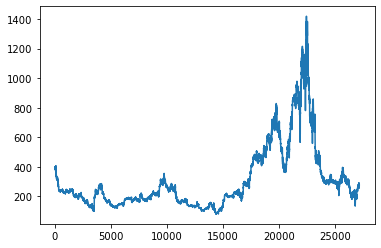

In [3]:
plt.plot(ethData['Close'])

In [4]:
prices = ethData['Close'].to_numpy()

targets = np.append(prices[1:], prices[-1])

print(prices[:5])
print(targets[:5])

print(prices.size, targets.size)

[396.12 394.97 399.52 399.68 397.69]
[394.97 399.52 399.68 397.69 392.8 ]
27149 27149


In [5]:
seq_len = 24
data=[]
for i in range(seq_len, prices.size):
    data.append((prices[i-seq_len:i], targets[i]))


In [6]:
real_prices = data[-3000:]#this will be used later to plot real data vs predicitons
data = data[:-3000]
random.shuffle(data)
data[0]

(array([591.61, 592.43, 590.56, 589.99, 591.99, 590.24, 594.88, 593.79,
        588.  , 586.99, 580.15, 573.99, 573.  , 579.15, 577.32, 575.41,
        578.89, 578.32, 568.7 , 562.96, 571.5 , 566.  , 566.97, 572.44]),
 574.75)

In [7]:
n=len(data)
train=int(0.7*n)
valid=int(0.2*n)
test=int(0.1*n)

train_data=data[:train]
valid_data=data[train:train+valid]
test_data=data[-test:]

In [8]:
#TODO: fix error when specifying larger batch size than 1 --- FIXED
batch_size=64

trainLoader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle=True)
validLoader = torch.utils.data.DataLoader(valid_data,batch_size = batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(test_data,batch_size = batch_size, shuffle=True)

In [9]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


## LSTM based RNN model
Here I define the model with several LSTM layers, and 2 Linear layers. Hyperparameters were adjusted until the model with the lowest validation loss was chosen.

In [10]:
class rnn_model(nn.Module):
    def __init__(self, input_size, n_hidden, n_layers, n_out):
        super().__init__()
        
        self.n_hidden=n_hidden
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, batch_first = True, dropout = 0.3)
        self.fcn1 = nn.Linear(n_hidden, 128)
        self.fcn2 = nn.Linear(128, n_out)#single value for regression
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, hidden):
        #x input shape is (batch_size, seq_len, features)
        lstm_out, hidden = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(-1,self.n_hidden) #reshape lstm output for fcl
        output=self.fcn1(lstm_out)
        output = self.dropout(output)
        output=self.fcn2(output)
        #sig_out = self.sig(output)
        #print(x.size(0))
        output = output.view(x.size(0),-1)
        return output[:,-1], hidden #return last prediction for each batch, and the hidden state
    
    def init_hidden(self,batch_size):
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        
rnn = rnn_model(1,64,2,1)
rnn

rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [12]:

epochs=300
counter=0
clip=5 #gradient clipping to prevent exploding gradients common in lstms
print_every=200

train_losses=[]
valid_losses=[]

if train_on_gpu:
    rnn.cuda()
    
rnn.train()
for e in range(epochs):
    #initialize hidden state
    h = rnn.init_hidden(batch_size)
    print("Epoch", e)
    for inputs, labels in trainLoader:
        counter+=1
        
        #if cuda is available, push data to gpu
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
            
        #reshape inputs and convert to float
        inputs = inputs.float().unsqueeze(-1)
        #print(inputs.shape)
        #print(inputs, labels)
        #make new variables for hidden state so back propagation doesnt occur through entire hidden layer history
        h = tuple([each.data for each in h])
        
        #clear out gradients
        rnn.zero_grad()
        
        #get model output
        out, h = rnn(inputs, h)
        
        #print(out, labels.shape)
        #calc loss and perform backpropagation
        loss = criterion(out.squeeze(0),labels.float())
        loss.backward()
        
        train_losses.append(loss.item())
        
        nn.utils.clip_grad_norm_(rnn.parameters(), clip)
        optimizer.step()
        
        #every few loops, print the loss and accuracy metrics
        if counter % print_every == 0:
            val_h = rnn.init_hidden(batch_size)
            val_losses = []
            rnn.eval()
            for inputs, labels in validLoader:
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
                val_h = tuple([each.data for each in val_h])
                inputs = inputs.float().unsqueeze(-1)
                val_out, val_h = rnn(inputs, val_h)
                
                val_loss = criterion(val_out.squeeze(0), labels.float())
                val_losses.append(val_loss.item())
            print('..training loss: ', round(loss.item()))
            
            print('validation loss: ', round(np.mean(val_losses)))
            valid_losses.append(np.mean(val_losses))
            rnn.train()

Epoch 0
..training loss:  40786
validation loss:  57867
Epoch 1
..training loss:  20328
validation loss:  27129
Epoch 2
..training loss:  12498
validation loss:  13918
Epoch 3
..training loss:  2294
validation loss:  8191
..training loss:  6550
validation loss:  6123
Epoch 4
..training loss:  4985
validation loss:  3874
Epoch 5
..training loss:  347
validation loss:  2893
Epoch 6
..training loss:  648
validation loss:  2149
..training loss:  1650
validation loss:  1573
Epoch 7
..training loss:  2590
validation loss:  1561
Epoch 8
..training loss:  2672
validation loss:  1447
Epoch 9
..training loss:  2896
validation loss:  899
..training loss:  1236
validation loss:  1087
Epoch 10
..training loss:  1256
validation loss:  1190
Epoch 11
..training loss:  1511
validation loss:  615
Epoch 12
..training loss:  603
validation loss:  504
..training loss:  2007
validation loss:  386
Epoch 13
..training loss:  449
validation loss:  322
Epoch 14
..training loss:  1247
validation loss:  534
Epoch

..training loss:  807
validation loss:  266
Epoch 122
..training loss:  426
validation loss:  143
Epoch 123
..training loss:  369
validation loss:  344
Epoch 124
..training loss:  1032
validation loss:  126
..training loss:  1295
validation loss:  285
Epoch 125
..training loss:  797
validation loss:  277
Epoch 126
..training loss:  180
validation loss:  170
Epoch 127
..training loss:  716
validation loss:  255
Epoch 128
..training loss:  545
validation loss:  343
..training loss:  977
validation loss:  427
Epoch 129
..training loss:  988
validation loss:  341
Epoch 130
..training loss:  430
validation loss:  178
Epoch 131
..training loss:  409
validation loss:  186
..training loss:  357
validation loss:  240
Epoch 132
..training loss:  647
validation loss:  201
Epoch 133
..training loss:  619
validation loss:  375
Epoch 134
..training loss:  222
validation loss:  195
..training loss:  604
validation loss:  167
Epoch 135
..training loss:  343
validation loss:  175
Epoch 136
..training l

Epoch 242
..training loss:  246
validation loss:  341
Epoch 243
..training loss:  1423
validation loss:  221
..training loss:  450
validation loss:  267
Epoch 244
..training loss:  499
validation loss:  443
Epoch 245
..training loss:  442
validation loss:  300
Epoch 246
..training loss:  419
validation loss:  390
..training loss:  880
validation loss:  453
Epoch 247
..training loss:  774
validation loss:  209
Epoch 248
..training loss:  272
validation loss:  162
Epoch 249
..training loss:  601
validation loss:  263
..training loss:  209
validation loss:  392
Epoch 250
..training loss:  313
validation loss:  351
Epoch 251
..training loss:  593
validation loss:  361
Epoch 252
..training loss:  325
validation loss:  323
Epoch 253
..training loss:  695
validation loss:  365
..training loss:  273
validation loss:  423
Epoch 254
..training loss:  479
validation loss:  317
Epoch 255
..training loss:  479
validation loss:  431
Epoch 256
..training loss:  537
validation loss:  245
..training lo

best losses were 159 for validation with 3 layers of 64 nodes each with a sequence length of 24 hours

72.52176666259766


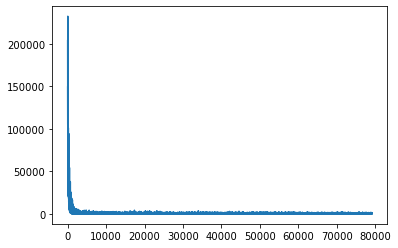

In [13]:
print(min(train_losses))
plt.plot(train_losses[:])

124.97775509482936


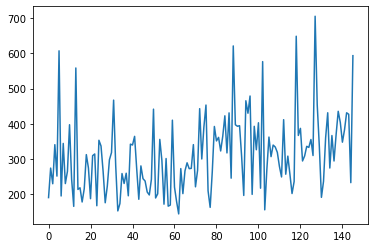

In [14]:
print(min(valid_losses))
plt.plot(valid_losses[250:])

In [15]:
tod = datetime.datetime.now()
test=crc.get_historical_price('ETH', 'USD',
                         timestamp=tod, exchange='Coinbase')

In [16]:
def get_past_days(num_days=5,curr='ETH'):
    tod = datetime.datetime.now()
    prices=[]
    for i in range(num_days+1,1,-1):
        d = datetime.timedelta(days = i)
        a = tod - d
        price=crc.get_historical_price(curr, 'USD',
                         timestamp=a, exchange='Coinbase')
        prices.append(price[curr]['USD'])
    return prices
p=get_past_days(seq_len + 1)
p

[372.21,
 386.22,
 389.82,
 401.21,
 395.28,
 379.75,
 397.51,
 390.41,
 395.78,
 378.88,
 387.27,
 424.94,
 438.83,
 432.55,
 433.7,
 431.5,
 422.31,
 407.59,
 415.92,
 388.05,
 395.62,
 390.67,
 407.98,
 383.33,
 386.1]

In [17]:
future = p[:]
#future = [121.83, 120.66, 122.  , 120.99, 122.76, 126.78, 127.43, 128.13,
#        127.16, 128.75, 130.3 , 131.35, 131.94, 131.67, 131.32, 131.12,
#        130.84, 130.79, 131.49, 131.43, 131.76, 132.24, 132.3 , 132.28]
#future.append(421.08)

#future = [393.71, 389.74, 390.87, 385.61, 380.49, 381.65, 384.97]

future = torch.Tensor(future)

In [18]:
rnn.eval()
future=future.float().view(1,-1,1)
prediction = rnn(future.cuda(), rnn.init_hidden(1))
print(prediction[0].item(), test['ETH']['USD'])
rnn.train()

403.3792419433594 393.36


rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [19]:
rnn.eval()
n=5000
correct = 0
hid = rnn.init_hidden(batch_size)
for sequence in data[:n]:
    inputs = torch.Tensor(sequence[0]).float().view(1,-1,1)
    labels = sequence[1]
    inputs = inputs.cuda()
    output, hid = rnn(inputs, hid)
    if int(output[0].item() >  sequence[0][-1]) == int(labels > sequence[0][-1]):
        correct += 1

print('Accuracy is: ', 100*correct / n, '%')
    
rnn.train()

Accuracy is:  49.88 %


rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [20]:
def conv_list(l, cuda):
    t = torch.Tensor(l).float().view(1,-1,1)
    if cuda:
        return t.cuda()
    return t

In [21]:
rnn.eval()
hid = rnn.init_hidden(batch_size)
predictions = []
real = []
for previous, target in real_prices:
    inputs = conv_list(previous, True)
    output, hid = rnn(inputs, hid)
    predictions.append(output[0].item())
    real.append(target)
rnn.train()  

rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

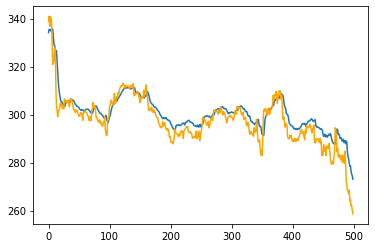

In [22]:
plt.plot(predictions[500:1000])
plt.plot(real[500:1000], color='orange')

## Predicting Bear or Bull Indicators

In [33]:
indicator_data = []
ahead = 5
for i in range(seq_len, prices.size-ahead):
    future_trend = prices[i + ahead] - prices[i]
    future_trend = int(future_trend > 0) #convert to 1 bit integer representing increase or decrease trend
    indicator_data.append((prices[i-seq_len:i], future_trend))
random.shuffle(indicator_data)

In [34]:
rnn.eval()
n=1000
correct = 0
hid = rnn.init_hidden(batch_size)
for sequence in indicator_data[:n]:
    tmp = sequence[0]
    labels = sequence[1]
    for i in range(ahead):
        inputs = conv_list(tmp, True)
        inputs = inputs.cuda()
        output, hid = rnn(inputs, hid)
        tmp = np.append(tmp[1:],output.item())
    pred_trend = int(output.item() - sequence[0][-1] > 0)
    if pred_trend == labels:
        correct += 1
print('Accuracy is: ', 100*correct / n, '%')
    
rnn.train()Accuracy is:  52.5 %


Accuracy is:  52.5 %


rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Generate Fake Predicted Data

In [41]:
rnn.eval()
hid = rnn.init_hidden(batch_size)
seed = 10500
tmp = prices[seed:seed+seq_len]
fake_prices = []
for i in range(20):
        inputs = conv_list(tmp, True)
        inputs = inputs.cuda()
        output, hid = rnn(inputs, hid)
        tmp = np.append(tmp[1:],output.item())
        fake_prices.append(output.item())

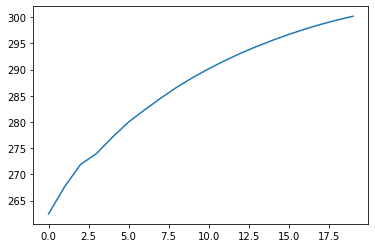

In [42]:
plt.plot(fake_prices)

In [3]:
def iterate(x):
    for i in range(x):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-3-a7633bdba358>, line 1)